<a href="https://githubtocolab.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/Chapter-7/3.Transfer%20learning-Stage_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random


import copy
import os
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report
from skimage.util import random_noise
import time


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Seed
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_seed = 12345

In [2]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [3]:
cropped_train_ds = ImageFolder('chest_xray_pre-processed/chest_xray/Cropped', 
                        transform = transforms.Compose([transforms.Resize((224,224)),
                                            transforms.RandomRotation(10),
                                            transforms.RandomGrayscale(),
                                            transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                           ]))
val_ds = ImageFolder('chest_xray_pre-processed/chest_xray/val', 
                        transform = transforms.Compose([transforms.Resize((224,224)),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                           ]))

len(cropped_train_ds), len(val_ds)


(422, 977)

In [4]:
batch_size=32

cropped_train_dl = DataLoader(cropped_train_ds, batch_size, shuffle=True, worker_init_fn=seed_worker)
val_dl = DataLoader(val_ds, batch_size, worker_init_fn=seed_worker)
loaders = {'train':cropped_train_dl, 'val':val_dl}
dataset_sizes = {'train':len(cropped_train_ds), 'val':len(val_ds)}

In [38]:
model = torch.load('Finetuning_Stage1.pt')

In [39]:
for param in model.parameters():
    param.requires_grad = False

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)

In [41]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}


def train(model, criterion, optimizer, scheduler, epochs):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
          loss.requires_grad = True
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()  
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model   

In [42]:
model.to(device)
epochs = 17
model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/17
train - loss:0.16213886227604374, accuracy0.9360189573459716
val - loss:0.05905295006321144, accuracy0.9815762538382805
Epoch: 2/17
train - loss:0.2181292337970146, accuracy0.9218009478672986
val - loss:0.09303262661174307, accuracy0.9733879222108496
Epoch: 3/17
train - loss:0.17090152465336694, accuracy0.9312796208530807
val - loss:0.09203716716300457, accuracy0.9723643807574207
Epoch: 4/17
train - loss:0.17591952452197743, accuracy0.9312796208530807
val - loss:0.08194925019857345, accuracy0.9744114636642784
Epoch: 5/17
train - loss:0.1736818109572781, accuracy0.9241706161137442
val - loss:0.07081017136284617, accuracy0.9785056294779939
Epoch: 6/17
train - loss:0.1652766755689377, accuracy0.9265402843601896
val - loss:0.06797165959056645, accuracy0.9795291709314228
Epoch: 7/17
train - loss:0.17079675276498907, accuracy0.9454976303317536
val - loss:0.08522375099469713, accuracy0.9744114636642784
Epoch: 8/17
train - loss:0.16720860655159112, accuracy0.9454976303317536
val - 

In [46]:
torch.save(model, 'Finetuning_Stage2.pt')

## Model Evaluation on Test Set

In [47]:
testset = ImageFolder('chest_xray_pre-processed/chest_xray/test', 
                           transform=torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), 
                                                 torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),                                                               
                                                 
                                                ]))

In [48]:
test_dl = DataLoader(testset, batch_size=256)
model.to(device);


In [49]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

def validation(batch):
        images,labels = batch
        images,labels = images.to(device),labels.to(device)
        output = model(images)                                      
        loss = F.cross_entropy(output, labels)                    
        acc,predictions = accuracy(output, labels)                       
        
        return {'valid_loss': loss.detach(), 'valid_accuracy':acc.detach(), 'predictions':predictions.detach(), 'labels':labels.detach()}
    
@torch.no_grad()
def test_predict(model, test_dataloader):
    model.eval()
    
    outputs = [validation(batch) for batch in test_dataloader] 
    batch_losses = [x['valid_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()           
    batch_accs = [x['valid_accuracy'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()             
  
    batch_preds = [pred for x in outputs for pred in x['predictions'].tolist()] 
    batch_labels = [label for x in outputs for label in x['labels'].tolist()]  
    
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(epoch_loss.item(), epoch_acc.item()))
    
    return batch_preds, batch_labels    

In [50]:
preds,labels = test_predict(model, test_dl)

test_loss: 0.2626, test_acc: 0.9334


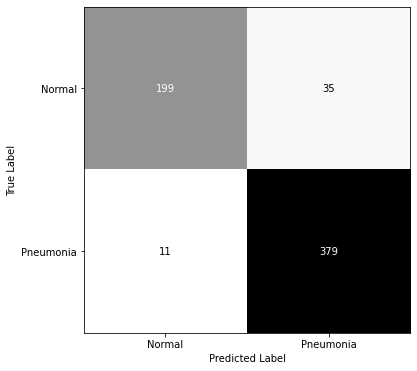

In [51]:
cm  = confusion_matrix(labels, preds)
plot_confusion_matrix(cm,figsize=(8,6),cmap=plt.cm.Greys)
plt.xticks(range(2), ['Normal', 'Pneumonia'])
plt.yticks(range(2), ['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label',fontsize=10)
plt.ylabel('True Label',fontsize=10)
plt.show()

In [52]:

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       234
           1       0.92      0.97      0.94       390

    accuracy                           0.93       624
   macro avg       0.93      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624

